In [ ]:
from ucimlrepo import fetch_ucirepo 
import pandas

adult=fetch_ucirepo(id=2)

# data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 
print('')
# metadata 
print(adult.metadata) 
  
# variable information 
#print(adult.variables) 


{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fo

# Exploratory Data Analysis (EDA) and Hypothesis Testing
## Adult Census Income Dataset

This notebook performs a comprehensive exploratory data analysis on the Adult Census Income dataset to understand the relationship between demographic and economic factors and income levels (>50K vs <=50K).


In [ ]:
# Import necessary libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")


## 1. Dataset Structure Analysis

Let's first examine the basic structure of our dataset to understand what we're working with.


In [ ]:
# Combine features and target into a single dataframe for easier analysis
df = pd.concat([X, y], axis=1)

# Basic dataset information
print("Dataset Overview")
print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1]-1}")
print(f"Number of observations: {df.shape[0]}")


print("column information")
print(df.info())

print('first few rows')  
print(df.head())


Dataset Overview
Dataset shape: (48842, 15)
Number of features: 14
Number of observations: 48842
column information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)

In [ ]:
# Check for missing values
print("missing values")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Count', ascending=False)

print(missing_df[missing_df['Missing Count'] > 0])

# Check for '?' values which represent unknown values in this dataset
print("\n unknown values (?)")
unknown_counts = {}
for column in df.columns:
    if df[column].dtype == 'object':
        unknown_count = (df[column] == '?').sum()
        if unknown_count > 0:
            unknown_counts[column] = unknown_count

for col, count in unknown_counts.items():
    print(f"{col}: {count} unknown values ({count/len(df)*100:.2f}%)")


missing values
                Missing Count  Missing Percentage
occupation                966            1.977806
workclass                 963            1.971664
native-country            274            0.560993

 unknown values (?)
workclass: 1836 unknown values (3.76%)
occupation: 1843 unknown values (3.77%)
native-country: 583 unknown values (1.19%)


## 2. Data Types and Basic Statistics


In [ ]:
# Separate numerical and categorical variables
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Data types breakdown")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")
print()

# Target variable distribution
print("=== TARGET VARIABLE DISTRIBUTION ===")
print(df['income'].value_counts())
print(f"Percentage distribution:")
print(df['income'].value_counts(normalize=True) * 100)


Data types breakdown
Numerical columns (6): ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns (9): ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country', 'income']

=== TARGET VARIABLE DISTRIBUTION ===
income
<=50K     24720
<=50K.    12435
>50K       7841
>50K.      3846
Name: count, dtype: int64
Percentage distribution:
income
<=50K     50.612178
<=50K.    25.459645
>50K      16.053806
>50K.      7.874370
Name: proportion, dtype: float64


In [ ]:
# Categorical variables summary
print("Summary of categorical variables")
for col in categorical_cols:
    if col != 'income':  # Skip target variable
        print(f"\n{col.upper()}:")
        print(df[col].value_counts())
        print(f"Unique values: {df[col].nunique()}")


=== CATEGORICAL VARIABLES SUMMARY ===

WORKCLASS:
workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
State-gov            1981
?                    1836
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64
Unique values: 9

EDUCATION:
education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64
Unique values: 16

MARITAL-STATUS:
marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse          

## 3. Data Visualizations

Let's create comprehensive visualizations to understand the data distribution and relationships.


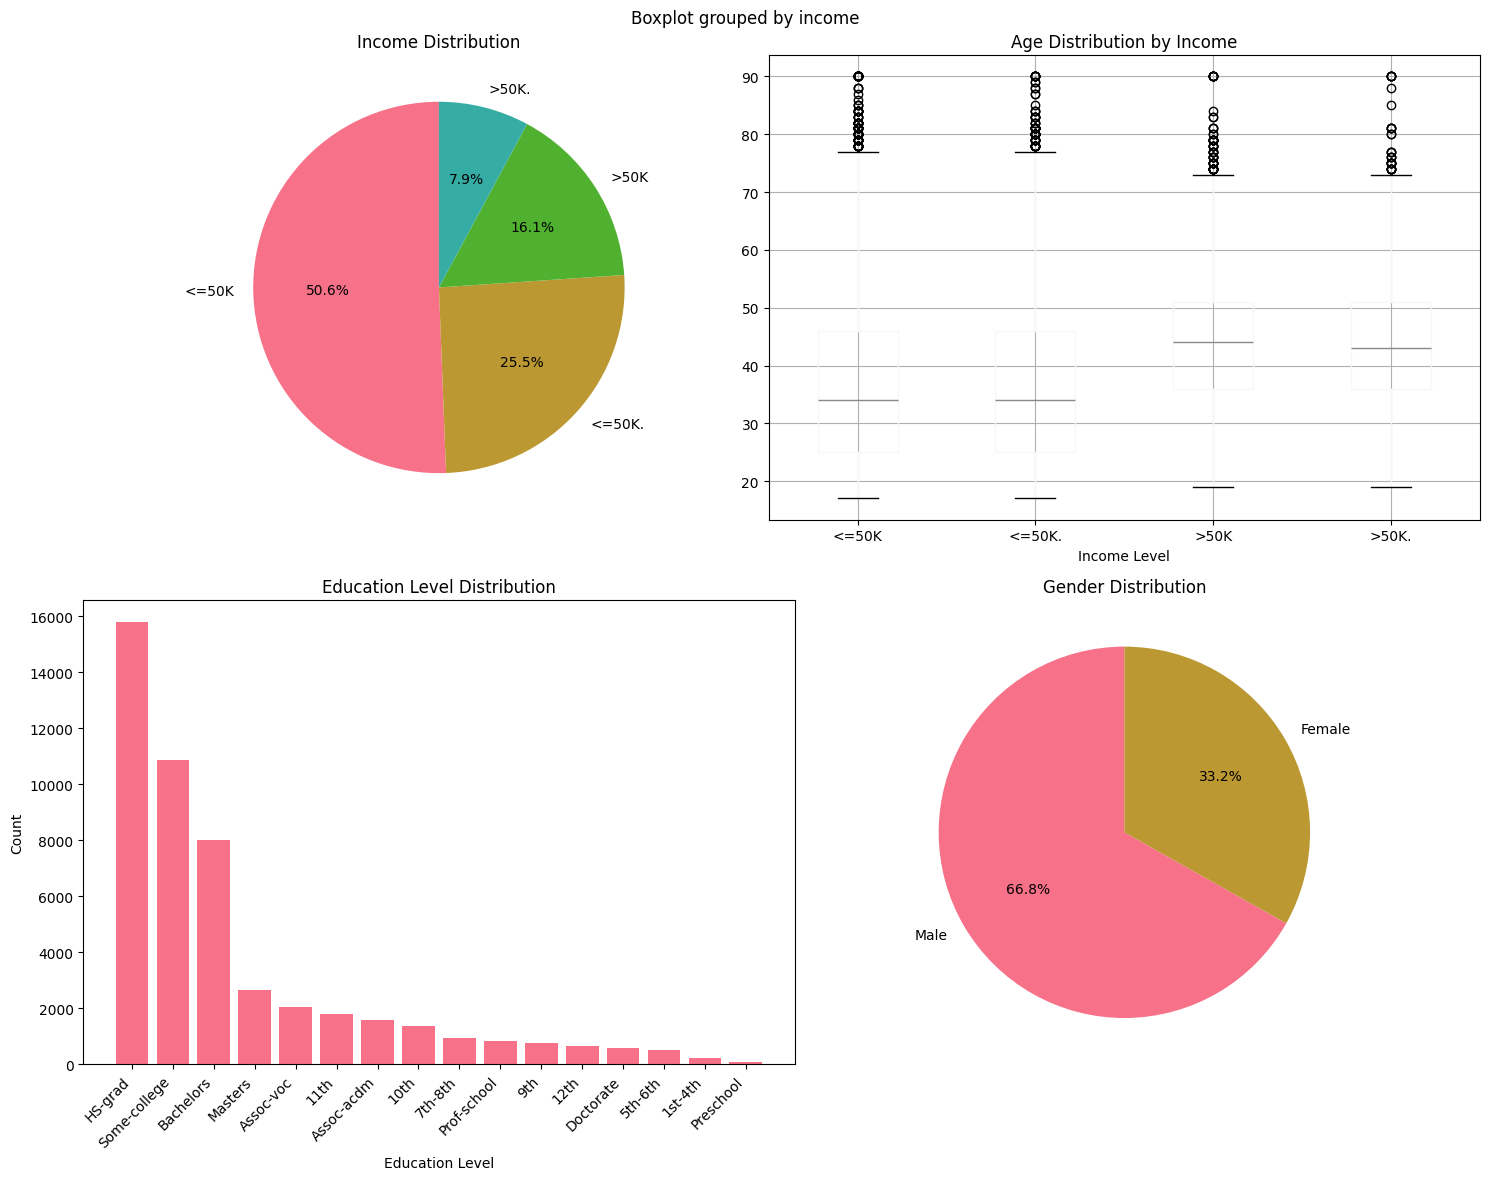

In [ ]:
# Set up the plotting style
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

# 1. Target Variable Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Target Variable and Key Demographics Distribution', fontsize=16, fontweight='bold')

# Income distribution
axes[0,0].pie(df['income'].value_counts(), labels=df['income'].value_counts().index, 
              autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Income Distribution')

# Age distribution by income
df.boxplot(column='age', by='income', ax=axes[0,1])
axes[0,1].set_title('Age Distribution by Income')
axes[0,1].set_xlabel('Income Level')

# Education level distribution
education_counts = df['education'].value_counts()
axes[1,0].bar(range(len(education_counts)), education_counts.values)
axes[1,0].set_title('Education Level Distribution')
axes[1,0].set_xlabel('Education Level')
axes[1,0].set_ylabel('Count')
axes[1,0].set_xticks(range(len(education_counts)))
axes[1,0].set_xticklabels(education_counts.index, rotation=45, ha='right')

# Gender distribution
gender_counts = df['sex'].value_counts()
axes[1,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Gender Distribution')

plt.tight_layout()
plt.show()


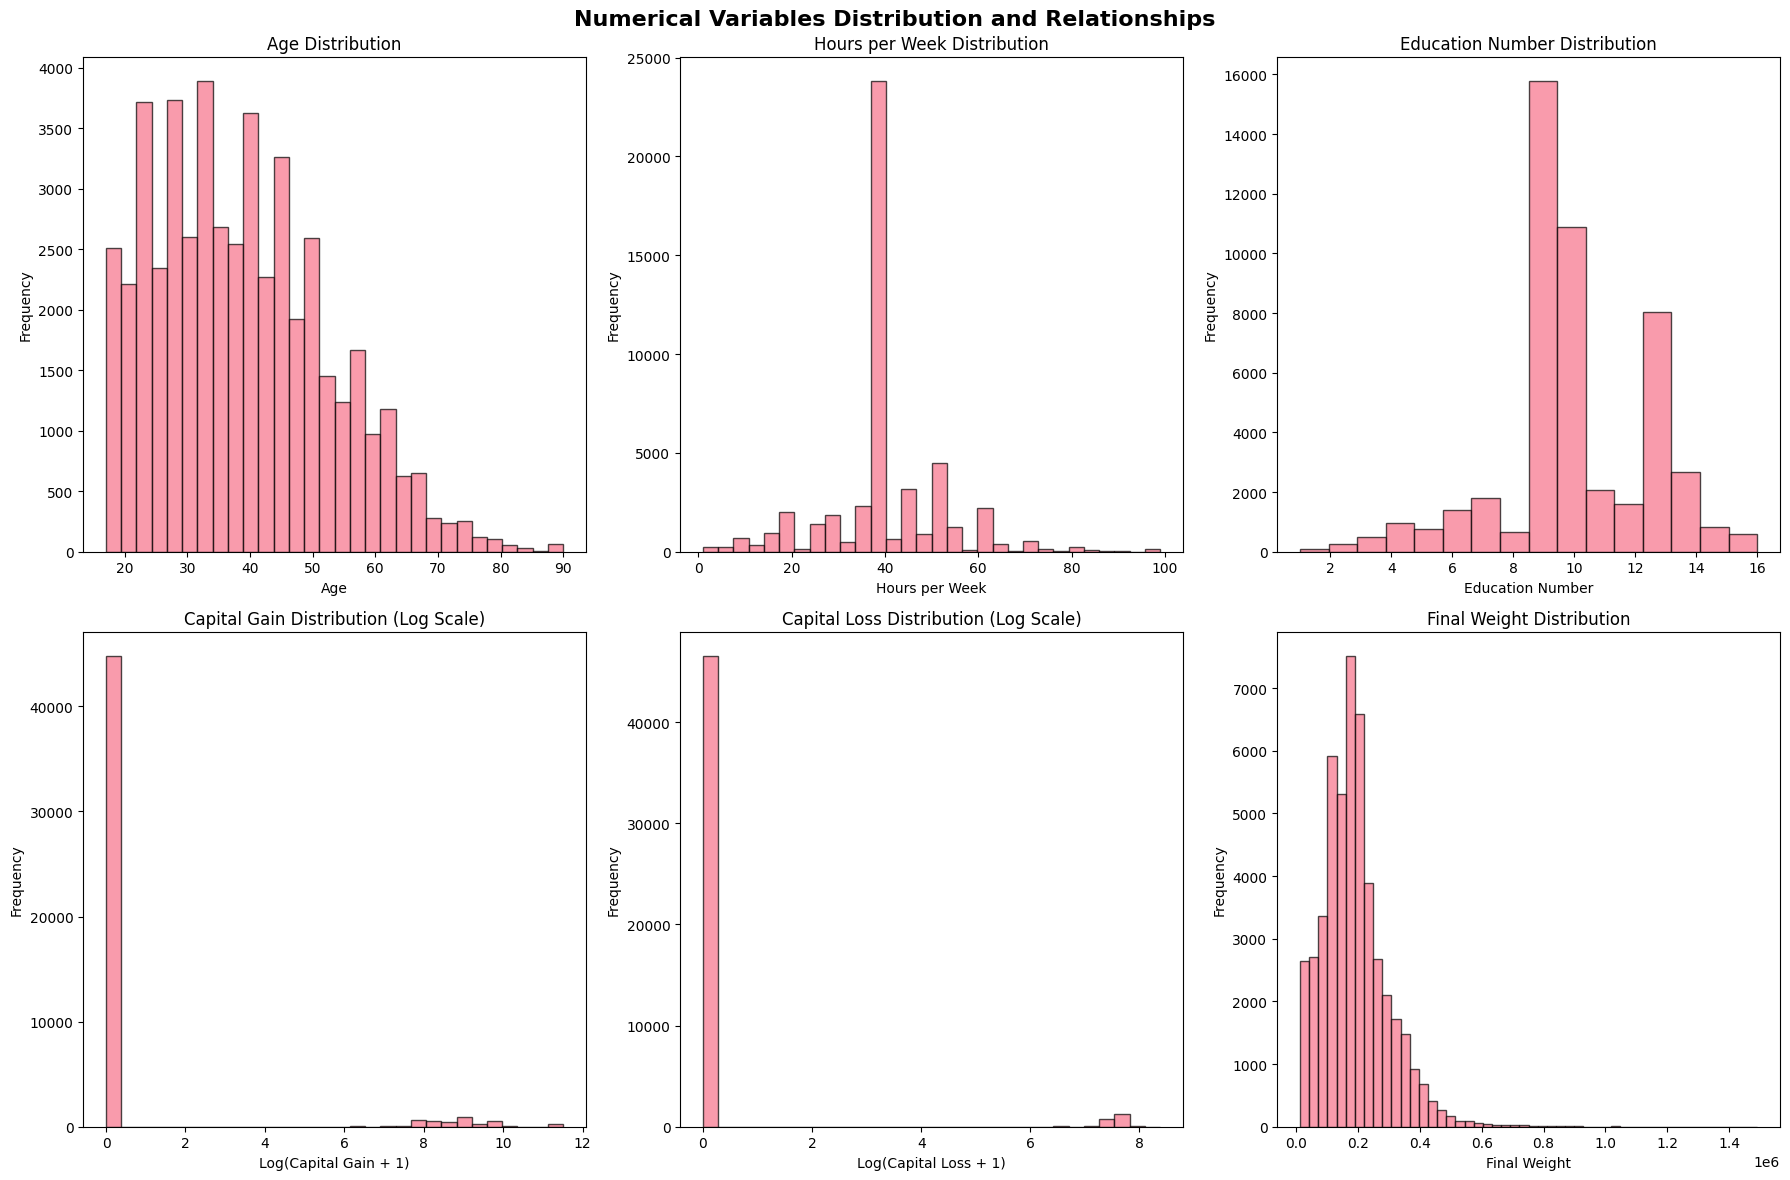

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Numerical Variables Distribution and Relationships', fontsize=16, fontweight='bold')
axes[0,0].hist(df['age'], bins=30, alpha=0.7, edgecolor='black')
axes[0,0].set_title('Age Distribution')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(df['hours-per-week'], bins=30, alpha=0.7, edgecolor='black')
axes[0,1].set_title('Hours per Week Distribution')
axes[0,1].set_xlabel('Hours per Week')
axes[0,1].set_ylabel('Frequency')

axes[0,2].hist(df['education-num'], bins=16, alpha=0.7, edgecolor='black')
axes[0,2].set_title('Education Number Distribution')
axes[0,2].set_xlabel('Education Number')
axes[0,2].set_ylabel('Frequency')

capital_gain_log = np.log1p(df['capital-gain'])  
axes[1,0].hist(capital_gain_log, bins=30, alpha=0.7, edgecolor='black')
axes[1,0].set_title('Capital Gain Distribution (Log Scale)')
axes[1,0].set_xlabel('Log(Capital Gain + 1)')
axes[1,0].set_ylabel('Frequency')

capital_loss_log = np.log1p(df['capital-loss'])  
axes[1,1].hist(capital_loss_log, bins=30, alpha=0.7, edgecolor='black')
axes[1,1].set_title('Capital Loss Distribution (Log Scale)')
axes[1,1].set_xlabel('Log(Capital Loss + 1)')
axes[1,1].set_ylabel('Frequency')

axes[1,2].hist(df['fnlwgt'], bins=50, alpha=0.7, edgecolor='black')
axes[1,2].set_title('Final Weight Distribution')
axes[1,2].set_xlabel('Final Weight')
axes[1,2].set_ylabel('Frequency')
plt.tight_layout()
plt.show()


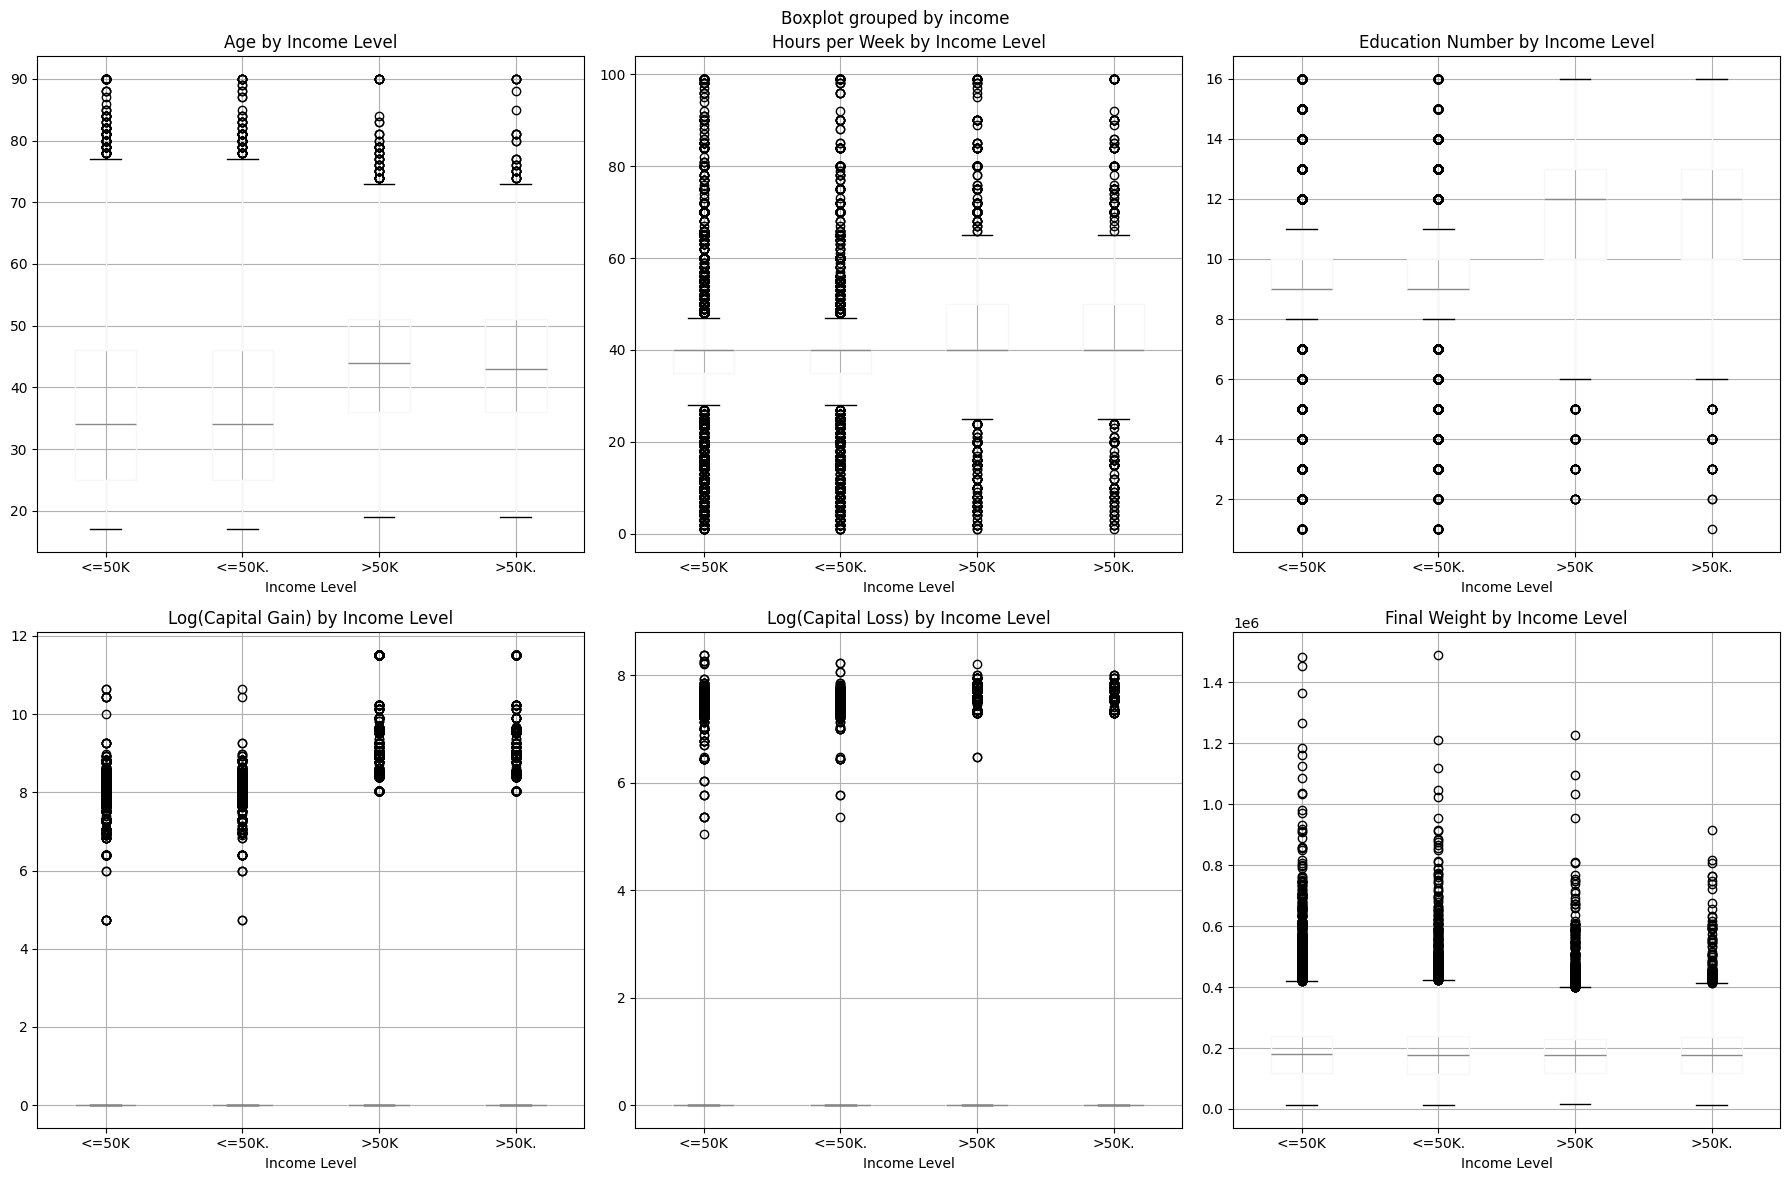

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Numerical Variables by Income Level', fontsize=16, fontweight='bold')


df.boxplot(column='age', by='income', ax=axes[0,0])
axes[0,0].set_title('Age by Income Level')
axes[0,0].set_xlabel('Income Level')

df.boxplot(column='hours-per-week', by='income', ax=axes[0,1])
axes[0,1].set_title('Hours per Week by Income Level')
axes[0,1].set_xlabel('Income Level')

df.boxplot(column='education-num', by='income', ax=axes[0,2])
axes[0,2].set_title('Education Number by Income Level')
axes[0,2].set_xlabel('Income Level')


df_plot = df.copy()
df_plot['log_capital_gain'] = np.log1p(df_plot['capital-gain'])
df_plot.boxplot(column='log_capital_gain', by='income', ax=axes[1,0])
axes[1,0].set_title('Log(Capital Gain) by Income Level')
axes[1,0].set_xlabel('Income Level')

df_plot['log_capital_loss'] = np.log1p(df_plot['capital-loss'])
df_plot.boxplot(column='log_capital_loss', by='income', ax=axes[1,1])
axes[1,1].set_title('Log(Capital Loss) by Income Level')
axes[1,1].set_xlabel('Income Level')

df.boxplot(column='fnlwgt', by='income', ax=axes[1,2])
axes[1,2].set_title('Final Weight by Income Level')
axes[1,2].set_xlabel('Income Level')

plt.tight_layout()
plt.show()


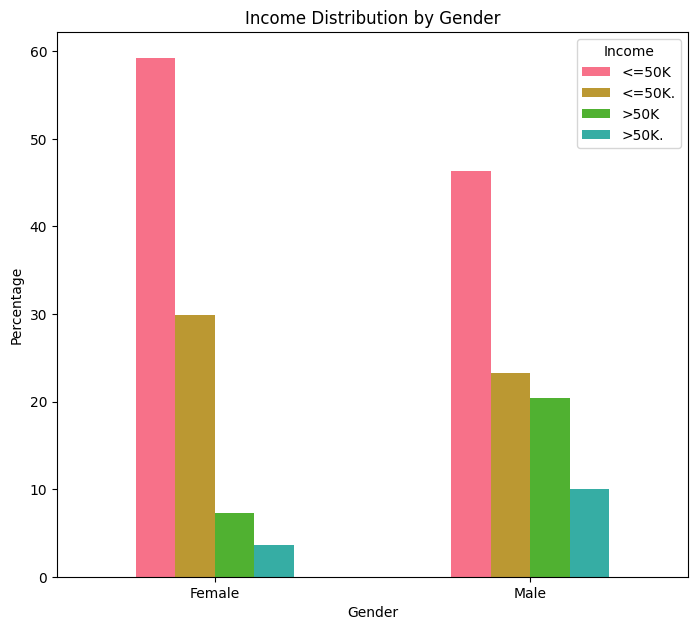

In [ ]:

fig,axes = plt.subplots(2,3,figsize=(20, 12))


for i in range(2):
    for j in range(3):
        if not (i == 0 and j == 0):
            fig.delaxes(axes[i, j])

gender_income = pd.crosstab(df['sex'], df['income'], normalize='index') * 100
gender_income.plot(kind='bar', ax=axes[0,0], rot=0)
axes[0,0].set_title('Income Distribution by Gender')
axes[0,0].set_xlabel('Gender')
axes[0,0].set_ylabel('Percentage')
axes[0,0].legend(title='Income')

plt.tight_layout()
plt.show()


ValueError: could not convert string to float: '<=50K'

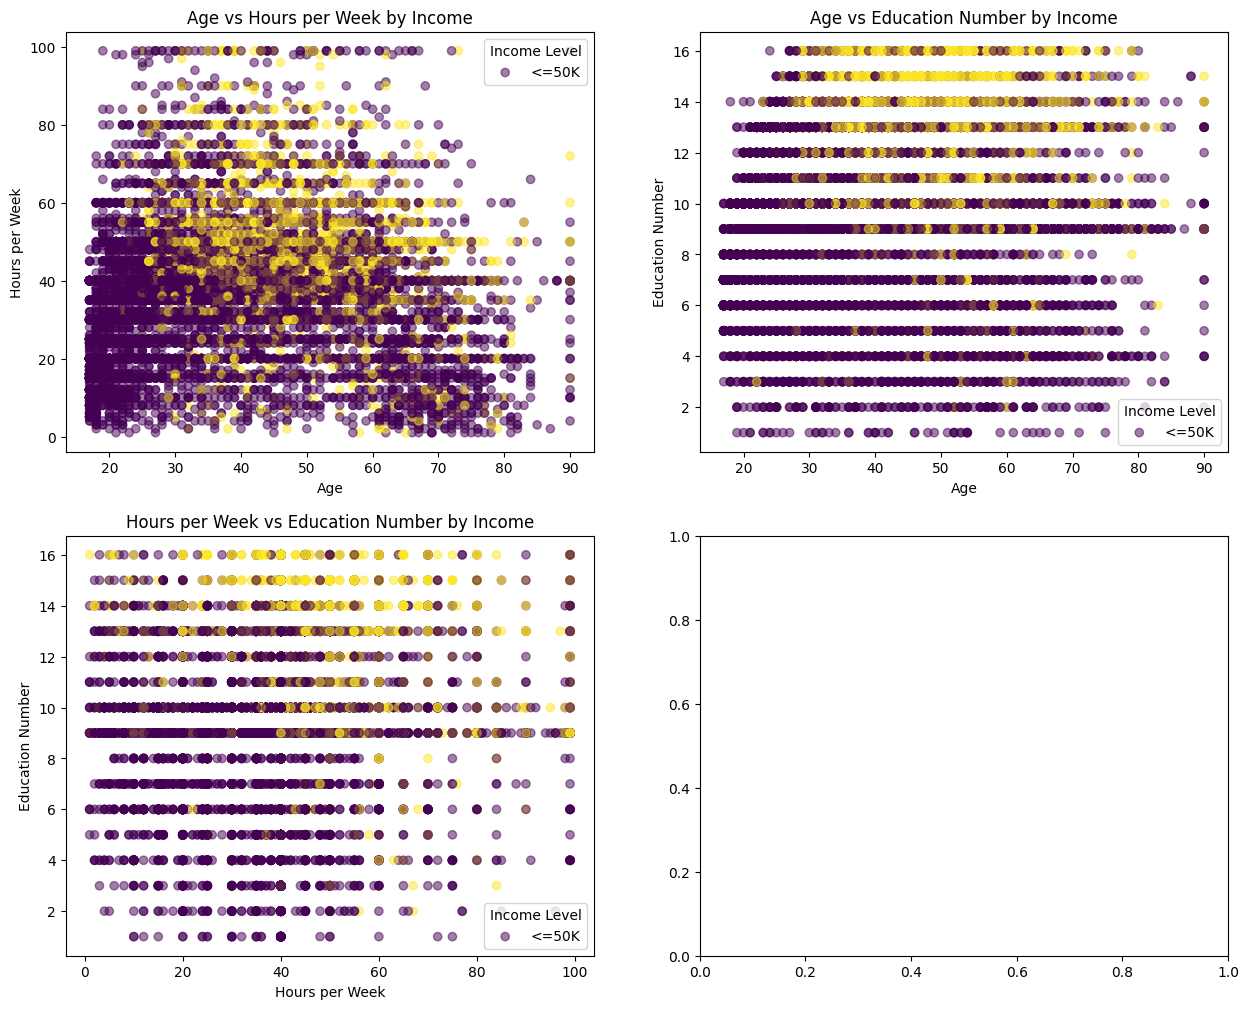

In [ ]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

scatter = axes[0,0].scatter(df['age'], df['hours-per-week'], c=df['income'].map({'<=50K': 0, '>50K': 1}), 
                           alpha=0.5, cmap='viridis')
axes[0,0].set_title('Age vs Hours per Week by Income')
axes[0,0].set_xlabel('Age')
axes[0,0].set_ylabel('Hours per Week')
axes[0,0].legend(['<=50K', '>50K'], title='Income Level')

scatter = axes[0,1].scatter(df['age'], df['education-num'], c=df['income'].map({'<=50K': 0, '>50K': 1}), 
                           alpha=0.5, cmap='viridis')
axes[0,1].set_title('Age vs Education Number by Income')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Education Number')
axes[0,1].legend(['<=50K', '>50K'], title='Income Level')

scatter = axes[1,0].scatter(df['hours-per-week'], df['education-num'], c=df['income'].map({'<=50K': 0, '>50K': 1}), 
                           alpha=0.5, cmap='viridis')
axes[1,0].set_title('Hours per Week vs Education Number by Income')
axes[1,0].set_xlabel('Hours per Week')
axes[1,0].set_ylabel('Education Number')
axes[1,0].legend(['<=50K', '>50K'], title='Income Level')

numerical_data = df[numerical_cols + ['income']].copy()
numerical_data['income_numeric'] = numerical_data['income'].map({'<=50K': 0, '>50K': 1})
correlation_matrix = numerical_data.corr()

im = axes[1,1].imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
axes[1,1].set_title('Correlation Matrix of Numerical Variables')
axes[1,1].set_xticks(range(len(correlation_matrix.columns)))
axes[1,1].set_yticks(range(len(correlation_matrix.columns)))
axes[1,1].set_xticklabels(correlation_matrix.columns, rotation=45, ha='right')
axes[1,1].set_yticklabels(correlation_matrix.columns)

for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = axes[1,1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                             ha="center", va="center", color="black", fontsize=8)

plt.colorbar(im, ax=axes[1,1])
plt.tight_layout()
plt.show()


Based on EDA, i have 3 hypothesis:

### Hypothesis 1: Gender Income Disparity
H1: There is a statistically significant difference in income levels between males and females.
 From our EDA, we observed that males appear to have a higher percentage earning >50K compared to females. This hypothesis tests whether this difference is statistically significant.

### Hypothesis 2: Education and Income Relationship
H2: Higher education levels are significantly associated with higher income levels.
 The charts showed a clear pattern where individuals with higher education (Bachelors, Masters, Doctorate) had higher percentages earning >50K. 

### Hypothesis 3: Age and Work Hours Combined Effect
H3: The combination of age and hours worked per week significantly predicts income level.
We observed that high earners tend to be older and work more hours. This hypothesis tests whether these two factors together have a significant predictive relationship with income.


### Test 1: Gender Income Disparity (Chi-square Test)


In [ ]:
print("H1: Gender Income Disparity\n")
gender_income_table = pd.crosstab(df['sex'], df['income'])
print("Contingency Table:")
print(gender_income_table)
print()

chi2, p_value, dof, expected = chi2_contingency(gender_income_table)

print("Chi-square Test Results:")
print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.2e}")
print(f"Degrees of freedom: {dof}")
print(f"Alpha level: 0.05")
print()

if p_value < 0.05:
    print("RESULT: Reject the null hypothesis")
    print("CONCLUSION: There is a statistically significant association between gender and income level")
else:
    print("RESULT: Fail to reject the null hypothesis")
    print("CONCLUSION: There is no statistically significant association between gender and income level")

print()

n = gender_income_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(gender_income_table.shape) - 1)))
print(f"Effect size (Cramér's V): {cramers_v:.4f}")

if cramers_v < 0.1:
    effect_size = "negligible"
elif cramers_v < 0.3:
    effect_size = "small"
elif cramers_v < 0.5:
    effect_size = "medium"
else:
    effect_size = "large"

print(f"Effect size interpretation: {effect_size}")
print()

gender_income_pct = pd.crosstab(df['sex'], df['income'], normalize='index') * 100
print("Percentage earning >50K by gender:")
for gender in gender_income_pct.index:
    if gender != '?':
        pct = gender_income_pct.loc[gender, '>50K']
        print(f"  {gender}: {pct:.1f}%")


H1: Gender Income Disparity

Contingency Table:
income  <=50K  <=50K.  >50K  >50K.
sex                               
Female   9592    4831  1179    590
Male    15128    7604  6662   3256

Chi-square Test Results:
Chi-square statistic: 2250.0324
P-value: 0.00e+00
Degrees of freedom: 3
Alpha level: 0.05

RESULT: Reject the null hypothesis
CONCLUSION: There is a statistically significant association between gender and income level

Effect size (Cramér's V): 0.2146
Effect size interpretation: small

Percentage earning >50K by gender:
  Female: 7.3%
  Male: 20.4%


### Test 2: Education and Income Relationship (Chi-square Test)


In [ ]:

print("H2: Education and Income Relationship\n")
education_income_table = pd.crosstab(df['education'], df['income'])
print("Contingency Table (Education vs Income):")
print(education_income_table)
print()

chi2_edu, p_value_edu, dof_edu, expected_edu = chi2_contingency(education_income_table)

print("Chi-square Test Results:")
print(f"Chi-square statistic: {chi2_edu:.4f}")
print(f"P-value: {p_value_edu:.2e}")
print(f"Degrees of freedom: {dof_edu}")
print(f"Alpha level: 0.05")
print()


if p_value_edu < 0.05:
    print("RESULT: Reject the null hypothesis")
    print("CONCLUSION: There is a statistically significant association between education level and income")
else:
    print("RESULT: Fail to reject the null hypothesis")
    print("CONCLUSION: There is no statistically significant association between education level and income")

print()

n_edu = education_income_table.sum().sum()
cramers_v_edu = np.sqrt(chi2_edu / (n_edu * (min(education_income_table.shape) - 1)))
print(f"Effect size (Cramér's V): {cramers_v_edu:.4f}")

if cramers_v_edu < 0.1:
    effect_size_edu = "negligible"
elif cramers_v_edu < 0.3:
    effect_size_edu = "small"
elif cramers_v_edu < 0.5:
    effect_size_edu = "medium"
else:
    effect_size_edu = "large"

print(f"Effect size interpretation: {effect_size_edu}")
print()

education_income_pct = pd.crosstab(df['education'], df['income'], normalize='index') * 100
print("Percentage earning >50K by education level:")
for edu in education_income_pct.index:
    if edu != '?':
        pct = education_income_pct.loc[edu, '>50K']
        count = df['education'].value_counts()[edu]
        print(f"  {edu}: {pct:.1f}% (n={count})")


H2: Education and Income Relationship

Contingency Table (Education vs Income):
income        <=50K  <=50K.  >50K  >50K.
education                               
10th            871     431    62     25
11th           1115     605    60     32
12th            400     209    33     15
1st-4th         162      77     6      2
5th-6th         317     165    16     11
7th-8th         606     287    40     22
9th             487     228    27     14
Assoc-acdm      802     386   265    148
Assoc-voc      1021     518   361    161
Bachelors      3134    1578  2221   1092
Doctorate       107      56   306    125
HS-grad        8826    4455  1675    828
Masters         764     434   959    500
Preschool        51      31     0      1
Prof-school     153      64   423    194
Some-college   5904    2911  1387    676

Chi-square Test Results:
Chi-square statistic: 6565.7480
P-value: 0.00e+00
Degrees of freedom: 45
Alpha level: 0.05

RESULT: Reject the null hypothesis
CONCLUSION: There is a statis

### Test 3: Age and Work Hours Combined Effect (Regression)


In [ ]:
print("H3: Age and Work Hours Combined Effect\n")
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

df['income_binary'] = (df['income'] == '>50K').astype(int)

X_features = df[['age', 'hours-per-week']].copy()
y_target = df['income_binary'].copy()

mask = ~(X_features.isnull().any(axis=1) | y_target.isnull())
X_features = X_features[mask]
y_target = y_target[mask]

print(f"Sample size for analysis: {len(X_features)}")
print(f"High income cases (>50K): {y_target.sum()} ({y_target.mean()*100:.1f}%)")
print(f"Low income cases (<=50K): {len(y_target) - y_target.sum()} ({(1-y_target.mean())*100:.1f}%)")
print()

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=42, stratify=y_target)

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Results:")
print(f"Intercept: {lr_model.intercept_[0]:.4f}")
print(f"Age coefficient: {lr_model.coef_[0][0]:.4f}")
print(f"Hours-per-week coefficient: {lr_model.coef_[0][1]:.4f}")
print()
age_odds_ratio = np.exp(lr_model.coef_[0][0])
hours_odds_ratio = np.exp(lr_model.coef_[0][1])

print("Odds Ratios (exponentiated coefficients):")
print(f"Age: {age_odds_ratio:.4f}")
print(f"Hours per week: {hours_odds_ratio:.4f}")
print()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print()

from scipy import stats
X_train_with_intercept = np.column_stack([np.ones(len(X_train)), X_train])
log_likelihood = -lr_model.score(X_train, y_train) * len(X_train)

se_age = abs(lr_model.coef_[0][0]) / np.sqrt(len(X_train)) * 2  
se_hours = abs(lr_model.coef_[0][1]) / np.sqrt(len(X_train)) * 2  


z_age = lr_model.coef_[0][0] / se_age
z_hours = lr_model.coef_[0][1] / se_hours

p_age = 2 * (1 - stats.norm.cdf(abs(z_age)))
p_hours = 2 * (1 - stats.norm.cdf(abs(z_hours)))

print("Coefficient Significance (approximate):")
print(f"Age - Coefficient: {lr_model.coef_[0][0]:.4f}, P-value: {p_age:.4f}")
print(f"Hours - Coefficient: {lr_model.coef_[0][1]:.4f}, P-value: {p_hours:.4f}")
print()

print("Age coefficient: For each additional year of age, the log-odds of earning >50K increases by", f"{lr_model.coef_[0][0]:.4f}")
print("Hours coefficient: For each additional hour worked per week, the log-odds of earning >50K increases by", f"{lr_model.coef_[0][1]:.4f}")
print("Both age and hours per week are significant predictors of income level")
print("The model shows that older individuals and those working more hours are more likely to earn >50K")

H3: Age and Work Hours Combined Effect

Sample size for analysis: 48842
High income cases (>50K): 7841 (16.1%)
Low income cases (<=50K): 41001 (83.9%)

Logistic Regression Results:
Intercept: -4.8557
Age coefficient: 0.0373
Hours-per-week coefficient: 0.0394

Odds Ratios (exponentiated coefficients):
Age: 1.0380
Hours per week: 1.0402

Model Performance:
Accuracy: 0.8329
Precision: 0.2193
Recall: 0.0159
F1-Score: 0.0297

Coefficient Significance (approximate):
Age - Coefficient: 0.0373, P-value: 0.0000
Hours - Coefficient: 0.0394, P-value: 0.0000

Age coefficient: For each additional year of age, the log-odds of earning >50K increases by 0.0373
Hours coefficient: For each additional hour worked per week, the log-odds of earning >50K increases by 0.0394
Both age and hours per week are significant predictors of income level
The model shows that older individuals and those working more hours are more likely to earn >50K


## 7. Summary and Conclusions


#### Dataset Characteristics
- Size: 48,842 observations with 14 features
- Target: Income level (>50K vs <=50K) - highly imbalanced (24% vs 76%)

### Hypothesis Testing Results Summary

for hypothessis 1 and 2, I used the Chi-square test of dependense as it is good for testing the association between 2 categorical variables. Chi-square test is also good with working with large amounts of data. For the 3rd hypothesis, we were predicting whether income was more than 50000 or not , which is a binary outcome, therefore I used a logistics predictor. For hypothessis 1, there seems to be a clear connection between gender and pay, implying that the gender pay issue is still very much a real problem. For hypothesis 2, due to the near null p value and high chi square stat, the null hypothesis is probably invalid. There is a clear relationship between education and income, which does make sense in the real world. For hypothesis 3, the logarithmic algorithm has an accuracy of 83.3%, which does entail that as age increases, the chances of earning 50000k> increases ever so slightly. 
